# Mount & Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/My Drive/Cardiac Project/Network_phase/mutgan

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/.shortcut-targets-by-id/1T4XU2DwFBpucge5DbMQ0wVZaRLkXQ564/Cardiac Project/Network_phase/mutgan


In [2]:
!pip install -q "monai-weekly[nibabel, tqdm, einops]"

In [3]:
!pip install neurite

In [4]:
from monai.transforms import (
    AsDiscrete,
    AddChanneld,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    ToTensord,
)

In [5]:
import os
import cv2
import numpy as np
import pickle
import neurite as ne
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load Data

## load from files

In [ ]:
def preprocess_mask(mask):
    new_mask = np.zeros((64, 64))
    mask = np.where(mask>101 , mask , 0)
    mask = np.where(mask !=0 , 1 , 0)
    return mask

In [ ]:
def read_a_patient_data(main_path):
    folder_nums = os.listdir(main_path)
    folder_nums = [f for f in folder_nums if len(f) == 1]
    dataset = []
    for folder_num in folder_nums:
        folder_path = main_path + "/" + folder_num
        files_in_folder_num = os.listdir(folder_path)
        if "cine_seri" not in files_in_folder_num:
                continue
        for file_in_folder_num in files_in_folder_num:
            seri_mask_dataset = []
            if "cine_seri" in file_in_folder_num:
                f_dataset = []
                cine_seri_folder = folder_path+"/"+file_in_folder_num
                images = os.listdir(cine_seri_folder)
                images = sorted(images)

                for image_name in images:
                    image_path = cine_seri_folder + "/" + image_name
                    image = cv2.imread(image_path , cv2.IMREAD_GRAYSCALE)
                    image = image/255
                    image = image.astype("float")
                    f_dataset.append(image)
            if "mask" in file_in_folder_num:
                mask_path = folder_path+"/"+file_in_folder_num
                mask = cv2.imread(mask_path , cv2.IMREAD_GRAYSCALE)
                mask = preprocess_mask(mask)
        f_dataset = np.stack(f_dataset , axis = 2)
        this_data_dict = dict()
        this_data_dict["image"] = f_dataset
        this_data_dict["label"] = mask 
        dataset.append(this_data_dict)      
    return dataset

In [ ]:
path = "../dataset/"
dataset = [] 
patient_ids = os.listdir(path)
for patient_id in patient_ids:
    patient_path = path + patient_id
    print(patient_id , end=",")
    patient_data = read_a_patient_data(patient_path)
    dataset.append(patient_data)

dataset = [item for sublist in dataset for item in sublist]

1616960,1602959,1617584,1601149,1431283,1283504,1417818,1412200,1458307,1449130,1461340,777161,1516218,1548638,903703,1523435,670643,423841,510347,746603,928508,1136533,1216198,1247592,1513957,1493313,1506521,1500375,1506547,1512085,1509723,1467583,1473669,1478427,1515081,1521169,1521531,1532303,1536189,1536656,1544054,1550461,1551489,1558213,1579030,1584473,1584634,1595517,1527564,1557463,1592107,

In [6]:
with open('./dataset.pkl', 'wb') as f:
     pickle.dump(dataset , f)

NameError: ignored

## load from pickle

In [7]:
# load dataset
with open('./data/dataset.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [8]:
# shape of dataset: list(dict), len(list) = 202
print(len(dataset))
print(dataset[0]['image'].shape)
print(dataset[0]['label'].shape)

202
(64, 64, 25)
(64, 64)


# Augmentation

In [44]:
to_tensor = Compose(
    [
        AddChanneld(keys=["image" , "label"]),
        ToTensord(keys=["image", "label"]),
    ]
)

rotate90 = Compose(
    [
        AddChanneld(keys=["image" , "label"]),
        RandRotate90d(keys=["image" , "label"], prob=1, spatial_axes=(0, 1)),
        ToTensord(keys=["image", "label"]),
    ]
)

flip = Compose(
    [
        AddChanneld(keys=["image" , "label"]),
        RandFlipd(keys=["image" , "label"], prob=1, spatial_axis=(1)),
        ToTensord(keys=["image", "label"]),
    ]
)

In [45]:
def make_augmentation(dataset , transform):
    new_dataset = []
    for element in dataset:
        transformed_element = transform(element)
        new_dataset.append(transformed_element)
    return new_dataset

In [46]:
_ , test_dataset = train_test_split(dataset , test_size = 0.1 , random_state = 0)
train_dataset , val_dataset = train_test_split(_ , test_size = 0.2 , random_state = 0)

In [47]:
main_train_dataset = make_augmentation(train_dataset , to_tensor)
rotated_train_dataset = make_augmentation(train_dataset , rotate90)
flipped_train_dataset = make_augmentation(train_dataset , flip)

val_dataset = make_augmentation(val_dataset , to_tensor)

test_dataset = make_augmentation(test_dataset , to_tensor)

# Visiaulize

In [48]:
def visualize(idx):
    m_img = main_train_dataset[idx]['image'][0, :, :, 10].numpy()
    m_lb = main_train_dataset[idx]['label'][0, :, :].numpy()
    
    r_img = rotated_train_dataset[idx]['image'][0, :, :, 10].numpy()
    r_lb = rotated_train_dataset[idx]['label'][0, :, :].numpy()

    f_img = flipped_train_dataset[idx]['image'][0, :, :, 10].numpy()
    f_lb = flipped_train_dataset[idx]['label'][0, :, :].numpy()

    fig , (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
    ax1.imshow(m_img, origin='lower', cmap='gray')
    ax2.imshow(r_img, origin='lower', cmap='gray')
    ax3.imshow(f_img, origin='lower', cmap='gray')
    ax1.set_title("main")
    ax2.set_title("rotated")
    ax3.set_title("flipped")

    fig , (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 15))
    ax1.imshow(m_lb, origin='lower', cmap='gray')
    ax2.imshow(r_lb, origin='lower', cmap='gray')
    ax3.imshow(f_lb, origin='lower', cmap='gray')
    ax1.set_title("main")
    ax2.set_title("rotated")
    ax3.set_title("flipped")

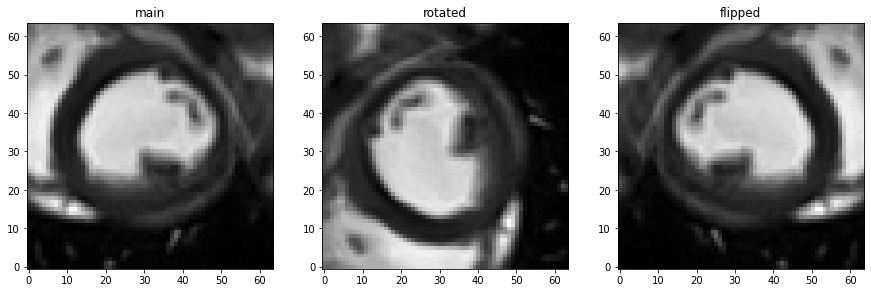

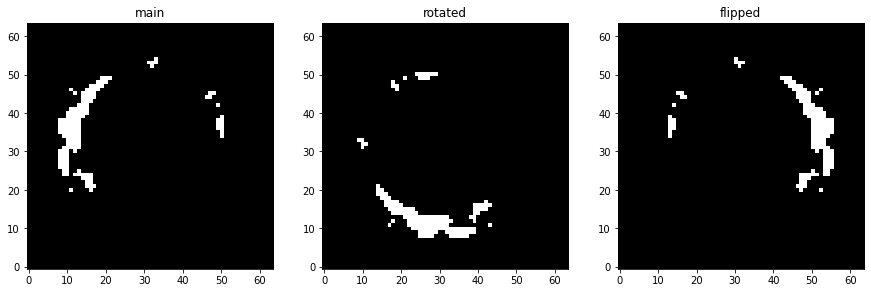

In [52]:
# 90 degree counter-clockwise
visualize(idx=0) 

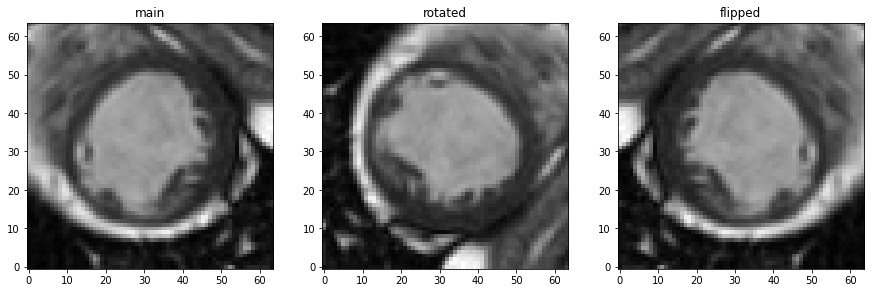

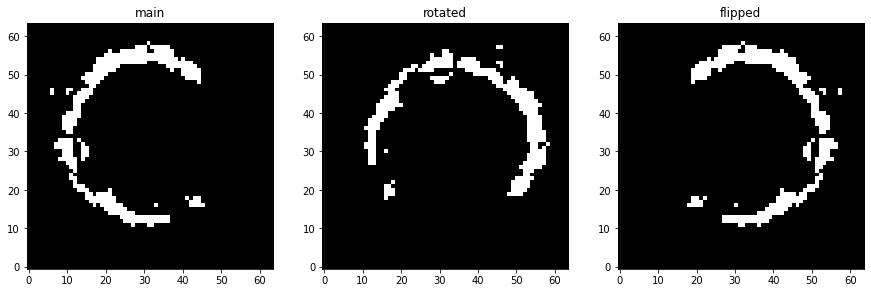

In [53]:
# 90 degree clockwise
visualize(idx=5)

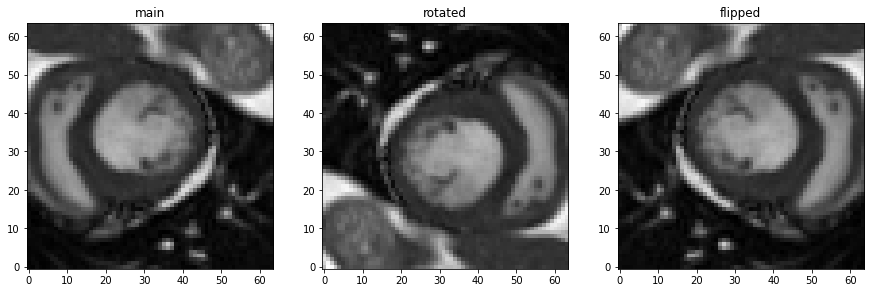

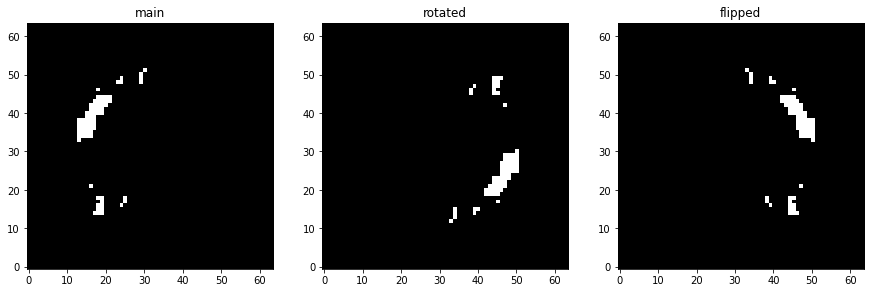

In [62]:
# 180 degree
visualize(idx=45)

# Save datasets

In [65]:
# save main datasets
with open('./data/train_dataset.pkl', 'wb') as f:
     pickle.dump(main_train_dataset , f)

with open('./data/val_dataset.pkl', 'wb') as f:
     pickle.dump(val_dataset , f)

with open('./data/test_dataset.pkl', 'wb') as f:
     pickle.dump(test_dataset , f)

# save augmented dataset

train_dataset_augmented = main_train_dataset + rotated_train_dataset + flipped_train_dataset
with open('./data/train_dataset_augmented.pkl', 'wb') as f:
     pickle.dump(train_dataset_augmented , f)